Unit - 3

In [1]:
import os
import librosa
import numpy as np
import pandas as pd
import soundfile as sf
from tqdm import tqdm

# Set root directory where the folders are
root_dir = r"C:\Users\Dell\Downloads\dev-clean\dev-clean"

# Supported extensions
AUDIO_EXTENSIONS = ('.wav', '.mp3', '.flac', '.ogg')

# List to hold data
data = []

# Walk through folders
for root, _, files in os.walk(root_dir):
    for file in files:
        if file.endswith(AUDIO_EXTENSIONS):
            full_path = os.path.join(root, file)
            try:
                y, sr = librosa.load(full_path, sr=16000)
                duration = librosa.get_duration(y=y, sr=sr)
                mfcc = librosa.feature.mfcc(y=y, sr=sr)
                pitch = librosa.yin(y, fmin=50, fmax=300)
                energy = np.sum(y**2)/len(y)
                
                snr_estimate = 10 * np.log10(np.mean(y**2) / (np.var(y - np.mean(y)) + 1e-8))
                
                data.append({
                    "file_path": full_path,
                    "duration_sec": duration,
                    "mfcc_mean": mfcc.mean(),
                    "pitch_mean": pitch.mean(),
                    "energy": energy,
                    "sentence": "unknown",
                    "snr_db": snr_estimate
                })
            except Exception as e:
                print(f"Error processing {full_path}: {e}")

# Convert to DataFrame
df = pd.DataFrame(data)

# Optional: classify audio as "clean" or "noisy" based on SNR threshold
df["label"] = df["snr_db"].apply(lambda x: "clean" if x > 10 else "noisy")

# Save for Power BI
df.to_csv("audio_features_metadata_3.csv", index=False)
print("Metadata and features saved.")


Metadata and features saved.


In [2]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s']", "", text)  # remove special characters
    text = re.sub(r"\s+", " ", text).strip()  # collapse multiple spaces
    return text

# Apply to your DataFrame
df["cleaned_text"] = df["sentence"].apply(clean_text)


In [3]:
import librosa
import numpy as np
import noisereduce as nr

def preprocess_audio(path):
    y, sr = librosa.load(path, sr=16000)
    
    # Normalize audio
    y = y / np.max(np.abs(y))
    
    # Voice activity detection (simple energy threshold)
    energy = librosa.feature.rms(y=y).flatten()
    frames = np.nonzero(energy > 0.01)
    indices = librosa.frames_to_samples(frames)[0]
    
    if len(indices) > 0:
        y = y[indices[0]:indices[-1]]  # Trim silent edges

    # Optional: Noise reduction
    y_denoised = nr.reduce_noise(y=y, sr=sr)
    
    return y_denoised, sr

# Preview cleaned audio
cleaned_audio, sr = preprocess_audio(df["file_path"].iloc[0])


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df = df[df["cleaned_text"].notnull() & df["cleaned_text"].str.strip().ne("")]
df["file_exists"] = df["file_path"].apply(os.path.isfile)
df = df[df["file_exists"]]
print(f"✅ Valid pairs: {len(df)}")


✅ Valid pairs: 2703


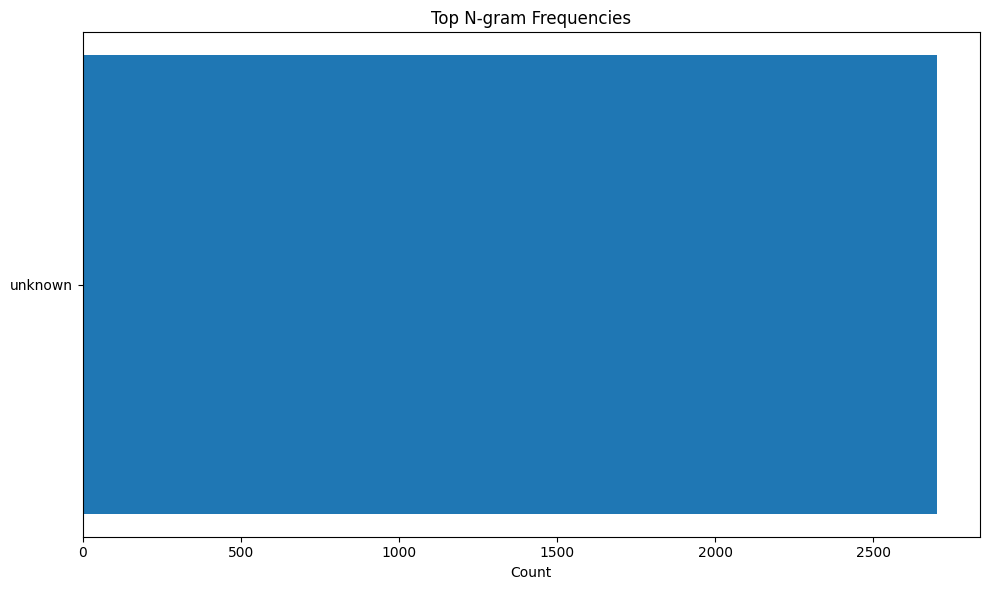

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Adjusted to avoid ValueError when n-grams are fewer than 20
top_n = min(20, len(vocab))  # Ensure we don't exceed available features

sorted_idx = np.argsort(ngram_freq)[::-1][:top_n]

plt.figure(figsize=(10, 6))
plt.barh(range(top_n), np.array(ngram_freq)[sorted_idx][::-1])
plt.yticks(range(top_n), np.array(vocab)[sorted_idx][::-1])
plt.title("Top N-gram Frequencies")
plt.xlabel("Count")
plt.tight_layout()
plt.show()



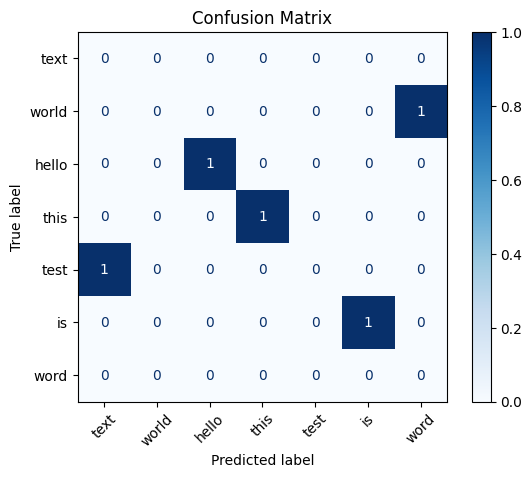

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Simulated: Replace with actual predicted vs true word labels
y_true = ["hello", "world", "this", "is", "test"]
y_pred = ["hello", "word", "this", "is", "text"]

cm = confusion_matrix(y_true, y_pred, labels=list(set(y_true + y_pred)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(y_true + y_pred)))
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


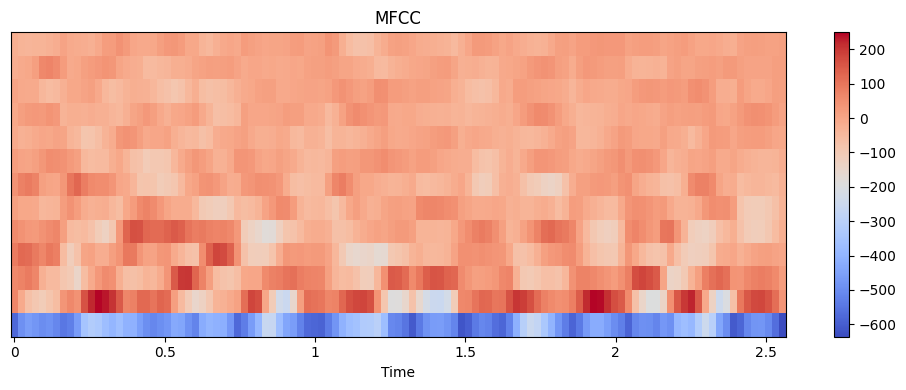

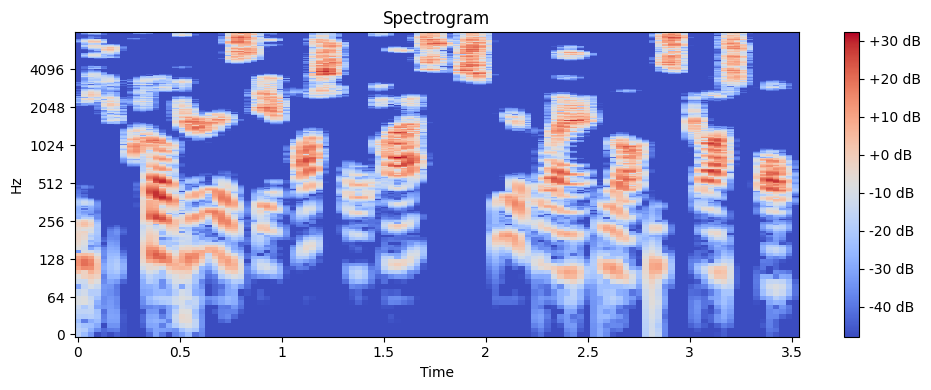

In [9]:
import librosa.display

audio_path = df["file_path"].iloc[0]
y, sr = librosa.load(audio_path, sr=16000)

# MFCC
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

# Spectrogram
S = librosa.stft(y)
S_db = librosa.amplitude_to_db(abs(S))
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.tight_layout()
plt.show()


In [29]:
import re

def regex_tokenizer(text):
    return re.findall(r'\b\w+\b', text.lower())

tokenized_text = [regex_tokenizer(text) for text in df["cleaned_text"]]



In [30]:
from collections import Counter
from itertools import islice

# Flatten token list
all_tokens = [word for tokens in tokenized_text for word in tokens]

# Generate n-grams
def generate_ngrams(tokens, n):
    return zip(*[tokens[i:] for i in range(n)])

# Count n-gram frequencies
unigrams = Counter(all_tokens)
bigrams = Counter(generate_ngrams(all_tokens, 2))
trigrams = Counter(generate_ngrams(all_tokens, 3))

# Display top 10
print("Top Unigrams:", unigrams.most_common(10))
print("Top Bigrams:", bigrams.most_common(10))
print("Top Trigrams:", trigrams.most_common(10))


Top Unigrams: [('unknown', 2703)]
Top Bigrams: [(('unknown', 'unknown'), 2702)]
Top Trigrams: [(('unknown', 'unknown', 'unknown'), 2701)]


In [32]:
from nltk.lm import MLE
from nltk.lm.preprocessing import padded_everygram_pipeline

# Prepare training data
train_data, vocab = padded_everygram_pipeline(3, tokenized_text)

# Train the model
lm = MLE(3)
lm.fit(train_data, vocab)

# Test prediction
print("Next word prediction for 'the quick brown':", lm.generate(1, text_seed=['the', 'quick', 'brown']))


Next word prediction for 'the quick brown': </s>


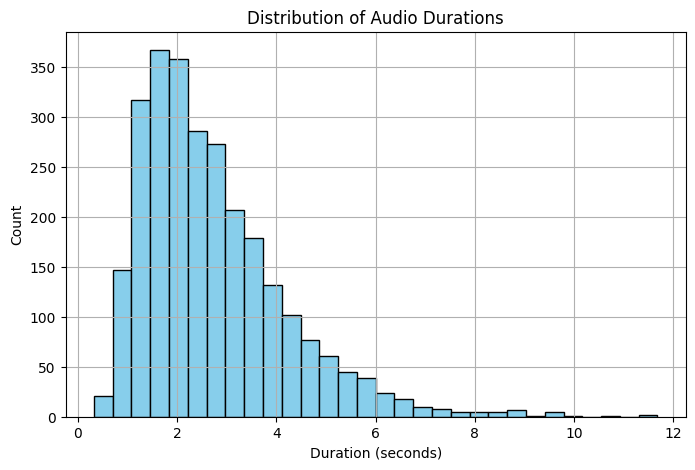

In [35]:
# Histogram of audio durations (in seconds)
plt.figure(figsize=(8, 5))
df["duration_sec"].hist(bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Audio Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.grid(True)
plt.show()


In [36]:
import librosa

# Compute durations if not available
df["duration"] = df["file_path"].apply(lambda path: librosa.get_duration(path=path))


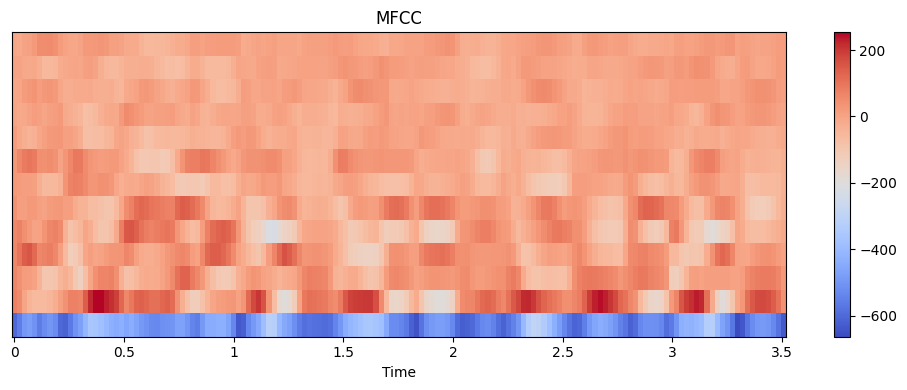

In [37]:
import librosa.display

# Visualize MFCCs for one sample
sample_path = df["file_path"].iloc[0]
y, sr = librosa.load(sample_path)
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title("MFCC")
plt.tight_layout()
plt.show()


In [40]:
import numpy as np

# Simulate energy-based VAD
df["vad_output"] = df["energy"].apply(lambda e: 1 if e > np.median(df["energy"]) else 0)

# If you want to simulate 'true_speech' for testing purposes (e.g., all 1s or random)
df["true_speech"] = np.random.choice([0, 1], size=len(df))

# Now compute precision, recall, etc.
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(df["true_speech"], df["vad_output"])
recall = recall_score(df["true_speech"], df["vad_output"])
f1 = f1_score(df["true_speech"], df["vad_output"])

print(f"Simulated VAD Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")



Simulated VAD Precision: 0.50, Recall: 0.51, F1: 0.50


In [41]:
from nltk.lm import MLE
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.util import ngrams

# Step 1: Prepare your data
# 'tokenized_text' is already created from your cleaned text
n = 3  # trigram model

# Step 2: Create n-gram training data
train_data, padded_vocab = padded_everygram_pipeline(n, tokenized_text)

# Step 3: Initialize and train the model
model = MLE(n)  # Maximum Likelihood Estimator
model.fit(train_data, padded_vocab)

# Step 4: Test the model on a few predictions
print("Example:", model.generate(10, text_seed=["the"]))


Example: ['<s>', 'unknown', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>']


In [45]:
df

,file_path,duration_sec,mfcc_mean,pitch_mean,energy,sentence,snr_db,label,cleaned_text,file_exists,duration,vad_output,true_speech
0,C:\Users\Dell\Downloads\dev-clean\dev-clean\12...,3.520,-24.762974,180.138132,0.004138,unknown,-0.000010,noisy,unknown,True,3.520,0,1
1,C:\Users\Dell\Downloads\dev-clean\dev-clean\12...,1.888,-22.541943,184.719576,0.007911,unknown,-0.000006,noisy,unknown,True,1.888,1,0
2,C:\Users\Dell\Downloads\dev-clean\dev-clean\12...,4.992,-26.878046,179.321852,0.004023,unknown,-0.000011,noisy,unknown,True,4.992,0,0
3,C:\Users\Dell\Downloads\dev-clean\dev-clean\12...,2.240,-21.327194,191.669593,0.008877,unknown,-0.000005,noisy,unknown,True,2.240,1,0
4,C:\Users\Dell\Downloads\dev-clean\dev-clean\12...,7.104,-25.808252,184.223368,0.004980,unknown,-0.000009,noisy,unknown,True,7.104,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2698,C:\Users\Dell\Downloads\dev-clean\dev-clean\88...,3.936,-28.229845,235.004684,0.002600,unknown,-0.000017,noisy,unknown,True,3.936,0,0
2699,C:\Users\Dell\Downloads\dev-clean\dev-clean\88...,3.872,-28.583942,222.680168,0.002254,unknown,-0.000019,noisy,unknown,True,3.872,0,1
2700,C:\Users\Dell\Downloads\dev-clean\dev-clean\88...,2.624,-24.445742,244.913914,0.003602,unknown,-0.000012,noisy,unknown,True,2.624,0,1
2701,C:\Users\Dell\Downloads\dev-clean\dev-clean\88...,2.720,-27.361959,236.144241,0.003520,unknown,-0.000013,noisy,unknown,True,2.720,0,1


In [48]:
import librosa
import numpy as np

# Define the feature extraction function
def extract_features(file_path, n_mfcc=13):
    # Load the audio file
    y, sr = librosa.load(file_path, sr=None)  # sr=None to preserve the original sampling rate
    
    # Extract MFCCs (Mel-frequency cepstral coefficients)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    
    # You can also extract other features here if needed, like chroma, spectral contrast, etc.
    # Example: chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    
    return mfcc, y, sr  # Return MFCCs, waveform (y), and sample rate (sr)


In [49]:
import pandas as pd

# Assuming df has a column 'file_path' which contains the paths to audio files
file_paths = df["file_path"].tolist()  # List of file paths from your dataframe

# Extract MFCCs for each file
mfcc_list = [extract_features(path)[0] for path in file_paths]  # Extract only the MFCCs

# Create a DataFrame to save the MFCCs
mfcc_df = pd.DataFrame({
    "file_path": file_paths,
    "mfcc": [mfcc.flatten().tolist() for mfcc in mfcc_list]  # Flatten MFCCs and convert to list
})

# Save the DataFrame to a CSV
mfcc_df.to_csv("audio_features.csv", index=False)




In [50]:
mfcc_df

,file_path,mfcc
0,C:\Users\Dell\Downloads\dev-clean\dev-clean\12...,"[-580.571533203125, -493.6214599609375, -460.1..."
1,C:\Users\Dell\Downloads\dev-clean\dev-clean\12...,"[-463.7266845703125, -375.3777160644531, -334...."
2,C:\Users\Dell\Downloads\dev-clean\dev-clean\12...,"[-605.6905517578125, -401.3551940917969, -247...."
3,C:\Users\Dell\Downloads\dev-clean\dev-clean\12...,"[-415.3362731933594, -319.4555358886719, -251...."
4,C:\Users\Dell\Downloads\dev-clean\dev-clean\12...,"[-484.9127502441406, -492.2499694824219, -496...."
...,...,...
2698,C:\Users\Dell\Downloads\dev-clean\dev-clean\88...,"[-454.3264465332031, -303.44146728515625, -225..."
2699,C:\Users\Dell\Downloads\dev-clean\dev-clean\88...,"[-527.6880493164062, -341.96807861328125, -243..."
2700,C:\Users\Dell\Downloads\dev-clean\dev-clean\88...,"[-419.9590148925781, -364.4233093261719, -372...."
2701,C:\Users\Dell\Downloads\dev-clean\dev-clean\88...,"[-555.102294921875, -405.0595397949219, -304.2..."
